In [1]:
import numpy as np
from astropy.io import ascii
from functions import *
from scipy.optimize import curve_fit
# from sklearn import neighbors
from astropy.table import Table
from astropy.io import fits
import numpy as np
import pickle
import scipy

In [2]:
print("loading data")
cols = ['Mstar',
        'u_r', 'g_r',
        'rabsmag',
        'SFR', 'sSFR', 'redshift',
        'flag_vsquared',
        'flag_voidfinder']

data = ascii.read('data_flags_updated_Oct14.dat', include_names=cols)

Mstar = data['Mstar']
# color
u_r = data['u_r']
g_r = data['g_r']
# absolute magnitude
rabsmag = data['rabsmag']
#star formation rate and specific SPR
SFR  = np.array(data['SFR'])
sSFR = np.array(data['sSFR'])

print("loading classification")
#classification V^2
wall_v2 = np.argwhere(data['flag_vsquared'] == 0).flatten()
void_v2 = np.argwhere(data['flag_vsquared'] == 1).flatten()
edge_v2 = np.argwhere(data['flag_vsquared'] == 2).flatten()
out_v2 = np.argwhere(data['flag_vsquared'] == 9).flatten()

#classification voidfinder
wall_vf = np.argwhere(data['flag_voidfinder'] == 0).flatten()
void_vf = np.argwhere(data['flag_voidfinder'] == 1).flatten()
edge_vf = np.argwhere(data['flag_voidfinder'] == 2).flatten()
out_vf = np.argwhere(data['flag_voidfinder'] == 9).flatten()

loading data
loading classification


In [3]:
ind_gal_depth_voidv2 = np.load('ind_gal_depth_voidv2_equal_slices.npy', allow_pickle=True)


In [4]:
hd = fits.open('galdepth7.fits', format='ascii')
new_depths = Table(hd[1].data)
# gal_depth = new_depths['GAL_ID'][(new_depths['DEPTH_NORM'] != -1)]
norm_depth = new_depths['DEPTH_NORM'][(new_depths['DEPTH_NORM'] != -1)]
norm_depth = np.array(norm_depth)
# norm_depth = np.flip(np.sort(norm_depth))

# len(norm_depth)

In [5]:
avg_depth_slice=[]
# temp=[]
for i in range(len(ind_gal_depth_voidv2)):
    avg_depth_slice.append(np.average(np.flip(np.sort(norm_depth))[:len(ind_gal_depth_voidv2[i])]))
#     print(j)
#     for i in range(len(ind_gal_depth_voidv2[j])):
#         temp.append(norm_depth[np.argwhere(gal_depth == ind_gal_depth_voidv2[j][i])])
#     avg_depth_slice.append(np.average(temp))
#     temp=[]

In [6]:
avg_depth_slice = np.flip(avg_depth_slice)

In [7]:
def ampl_ratio_err(x,dx,y,dy):
    '''
    returns the standard deviation of x/y
    '''
    return np.sqrt((dx/y)**2+((x*dy)/(y**2))**2)
    
# def ampl_diff_err(dx,dy):
#     '''
#     returns the standard deviation of x-y
#     '''
#     return np.sqrt(dx**2 + dy**2)  

In [8]:

def func_bimodal(x, a, mua, sga, askew, b, mub, sgb, bskew):
    '''returns a mixture of two skewnormal distributions'''
    return a*skewnorm.pdf(x, askew, loc=mua, scale=sga) + b*skewnorm.pdf(x, bskew, loc=mub, scale=sgb)
# def func_bimodal(x, a, mua, sga,b, mub, sgb):
#     '''returns a mixture of two skewnormal distributions'''
#     return a*norm.pdf(x, loc=mua, scale=sga) + b*norm.pdf(x, loc=mub, scale=sgb)


In [9]:
def func_bimodal1(x,a, mua, sga,askew):
    '''returns a mixture of two skewnormal distributions'''
    return a*skewnorm.pdf(x, askew, loc=mua, scale=sga)
# def func_bimodal1(x,a, mua, sga):
#     '''returns a mixture of two skewnormal distributions'''
#     return a*norm.pdf(x, loc=mua, scale=sga)

In [10]:
def bin_data(data,bins_,label, plot=False): 

    n1, edges1 = np.histogram(data, bins=bins_)
    dn1 = np.sqrt(n1)
    x = 0.5*(edges1[1:] + edges1[:-1])
        
    if plot == True:
        plt.errorbar(x, n1, yerr=dn1, fmt='.')        
        plt.xlabel(label, fontsize=18)
        plt.ylabel('count',fontsize=18) 
        plt.title("Binned Data ")
        plt.show()
            
# #     popt_wall, pcov_wall = curve_fit(func_bimodal, x, count_wall)
#     popt_void, pcov_void = curve_fit(func_bimodal, x, n1)

        
#     plt.errorbar(x, n1, yerr=dn1, fmt='.')  
#     plt.plot(x, func_bimodal(x, *popt_void), 'r-') #label='fit: a=%5.3f, mua=%5.3f, sga=%5.3f, askew=%5.3f, b=%5.3f, mub=%5.3f, sgb=%5.3f, bskew=%5.3f' % tuple(popt))
#     plt.title(label + " Void")
#     plt.xlabel(label)
#     plt.ylabel("Counts")
#     plt.show()
    
#     print(popt_void)
#     print(*popt_void)
        
    return  x,n1,dn1 #, popt_void

In [11]:
def bimodal_fit_void_separate(char_void, label, bins_):
    '''
    for example: char_= g_r, char_label= 'g-r', bins_=np.linspace(-0.5,1.5, 250)
    '''
    ## property variables
    print("loading property model variables")
    label_vf = label+'_VF'
    label_v2 = label+'_V2'
    
    
#     x, count_wall,dcount_wall = bin_data(char_wall,bins_,label)
    x, count_void,dcount_void = bin_data(char_void,bins_,label)
    
#     popt_wall, pcov_wall = curve_fit(func_bimodal, x, count_wall)
# a, mua, sga, askew, b, mub, sgb, bskew
# bounds=((-np.inf, -np.inf, 0,-np.inf,-np.inf,-np.inf,0,-np.inf), (-np.inf, -np.inf, 1,-np.inf,-np.inf,-np.inf,1,-np.inf))

    popt_void, pcov_void = curve_fit(func_bimodal, x, count_void, bounds=((-np.inf, -np.inf, 0,-np.inf,-np.inf,0,0,-np.inf), (np.inf, 0, 1,np.inf,np.inf,np.inf,1,np.inf))
 )
    
#     #begin test
#     print(popt_void)
#     plt.plot(x, count_void)
#     plt.show()
#     #end test
        
    plt.errorbar(x, count_void, yerr=dcount_void, fmt='.')  
    plt.plot(x, func_bimodal1(x, *popt_void[:4]), 'r-') #label='fit: a=%5.3f, mua=%5.3f, sga=%5.3f, askew=%5.3f, b=%5.3f, mub=%5.3f, sgb=%5.3f, bskew=%5.3f' % tuple(popt))
    plt.plot(x, func_bimodal1(x, *popt_void[4:]), 'g-') #label='fit: a=%5.3f, mua=%5.3f, sga=%5.3f, askew=%5.3f, b=%5.3f, mub=%5.3f, sgb=%5.3f, bskew=%5.3f' % tuple(popt))
    plt.plot(x, func_bimodal(x, *popt_void), 'black') #label='fit: a=%5.3f, mua=%5.3f, sga=%5.3f, askew=%5.3f, b=%5.3f, mub=%5.3f, sgb=%5.3f, bskew=%5.3f' % tuple(popt))

    plt.title(label + " Void")
    plt.xlabel(label)
    plt.ylabel("Counts")
    plt.show()
 

    plt.plot(x,func_bimodal(x, *popt_void)-count_void)
    plt.ylim(-np.max(count_void)/5,np.max(count_void)/5)
    plt.title('residuals')
    plt.show()
    
    return popt_void, np.sqrt(np.diag(pcov_void))
    

In [12]:
# def max_min_all(fit_result):
#     x1 = scipy.optimize.minimize_scalar(lambda x: -func_bimodal1(x,*fit_result[0][:4])).x
#     x2 = scipy.optimize.minimize_scalar(lambda x: -func_bimodal1(x,*fit_result[0][4:])).x
#     y1 = func_bimodal(x1,*fit_result[0])
#     y2 = func_bimodal(x2,*fit_result[0])
#     return np.max([y1,y2]), np.min([y1,y2])

In [13]:
# a1 = max_min_all(fit_all)[0]
# b1 = max_min_all(fit_all)[1]
def max_min(fit_result):
#     print(scipy.optimize.minimize_scalar(lambda x: -func_bimodal1(x,*fit_result[0][:4])).hess)
    x1 = scipy.optimize.minimize_scalar(lambda x: -func_bimodal1(x,*fit_result[0][:4])).x
    x2 = scipy.optimize.minimize_scalar(lambda x: -func_bimodal1(x,*fit_result[0][4:])).x
    y1 = func_bimodal(x1,*fit_result[0])
    y2 = func_bimodal(x2,*fit_result[0])
    return np.max([y1,y2]), np.min([y1,y2])

In [32]:
max_min(VF_void)

(1156.292907876931, 760.0813747690316)

loading property model variables


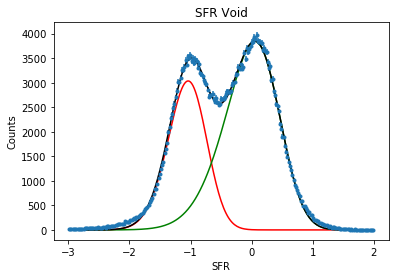

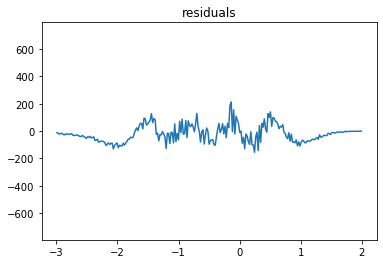

loading property model variables


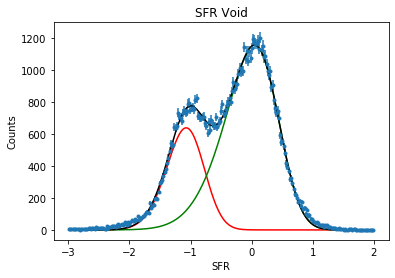

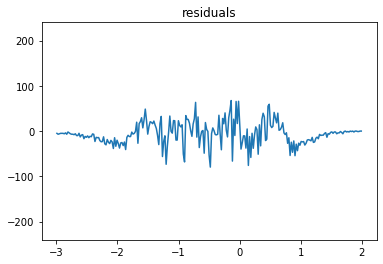

In [14]:
fit_all = bimodal_fit_void_separate(SFR[data['redshift']< 0.1026], 'SFR', bins_=np.linspace(-3,2, 250))
VF_void = bimodal_fit_void_separate(SFR[void_vf], 'SFR', bins_=np.linspace(-3,2, 250))


In [37]:
VF_void[1][0], VF_void[1][4], VF_void[0][0], VF_void[0][4]

(26.714718815115777, 26.817762561190484, 495.8392779957056, 1270.4887495762796)

In [40]:
ampl_ratio_err(VF_void[0][0], VF_void[1][0], VF_void[0][4], VF_void[1][4])

0.02258327723233253

In [39]:
amplitude_ratio_err

array([0.14828605, 0.13226093, 0.12489742, 0.20946814, 0.47222575,
       0.14431717, 0.1190196 , 0.31426085, 0.1021629 , 0.10636265,
       0.10359009, 0.09387253, 0.08638728, 0.25497678, 0.07324874,
       0.066299  , 0.20538501, 0.2421842 , 0.24545229, 0.06449734,
       0.06516525, 0.14909259, 0.06065512, 0.20485018, 0.20983702,
       0.05812642, 0.16876677, 0.19282244, 0.16392078, 0.05621508,
       0.05776476, 0.05653789, 0.14626382, 0.17095206, 0.16623278,
       0.16524324, 0.20878536, 0.0434916 , 0.05319287, 0.14953474,
       0.14885296, 0.14728163, 0.14522721, 0.06764581, 0.05670811,
       0.06122001, 0.0597123 ])

0
loading property model variables


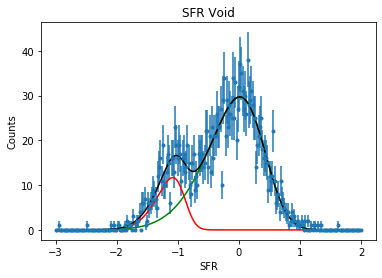

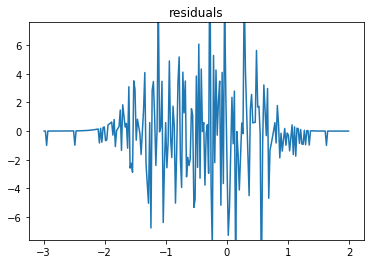

1
loading property model variables


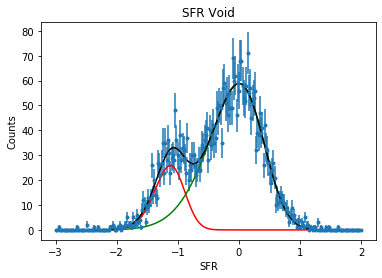

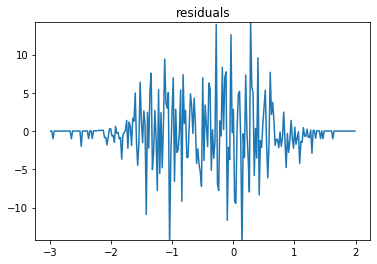

2
loading property model variables


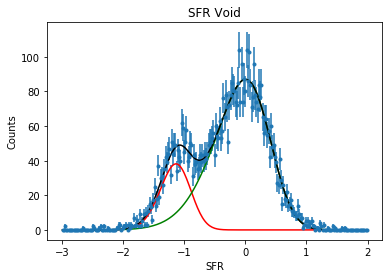

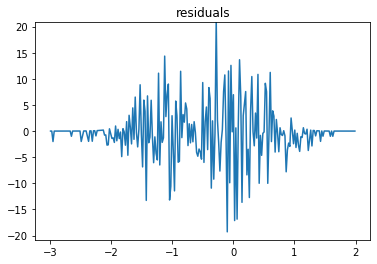

3
loading property model variables


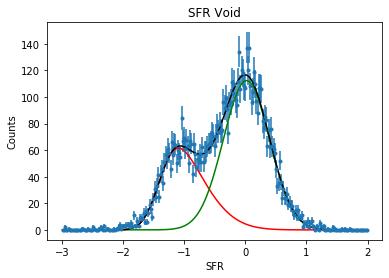

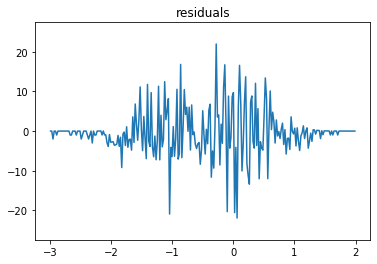

4
loading property model variables


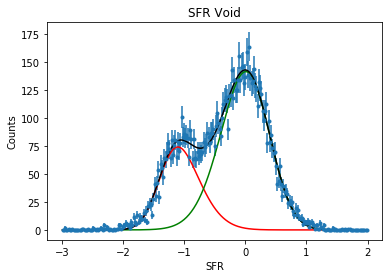

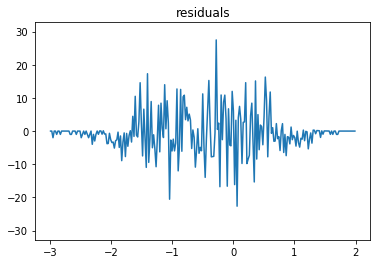

5
loading property model variables


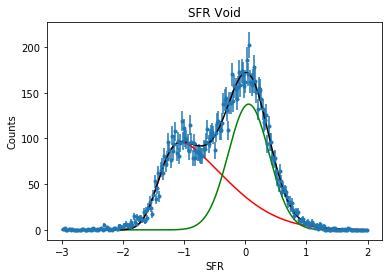

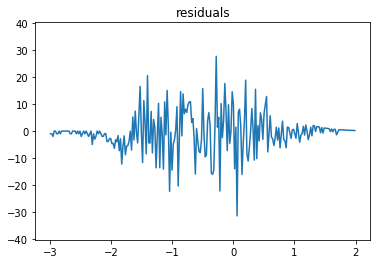

6
loading property model variables


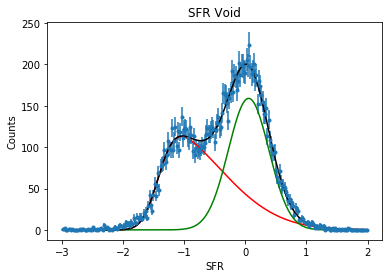

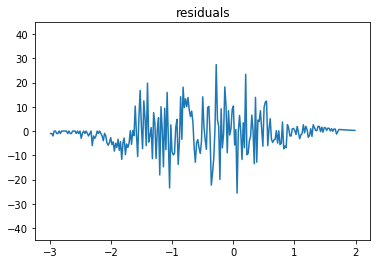

7
loading property model variables


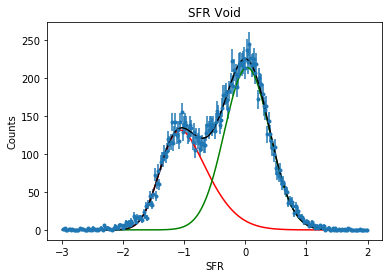

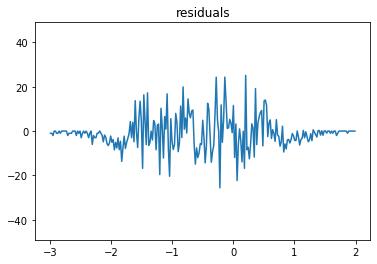

8
loading property model variables


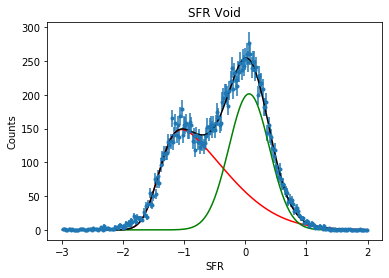

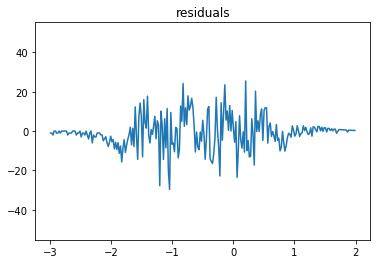

9
loading property model variables


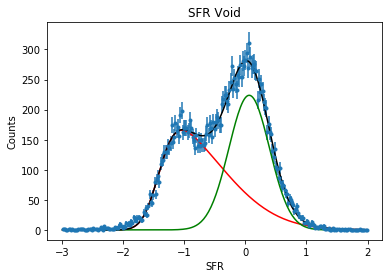

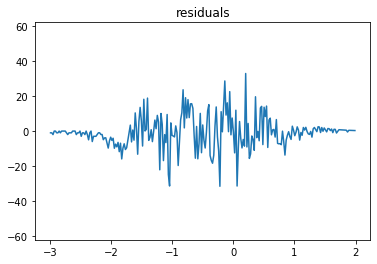

10
loading property model variables


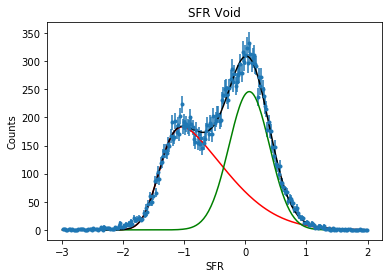

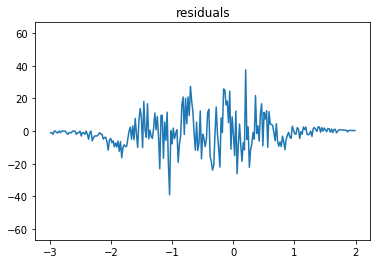

11
loading property model variables


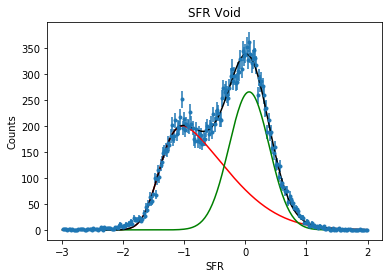

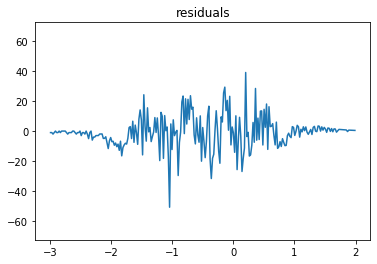

12
loading property model variables


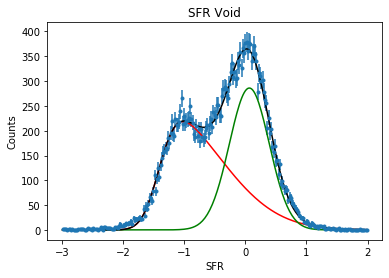

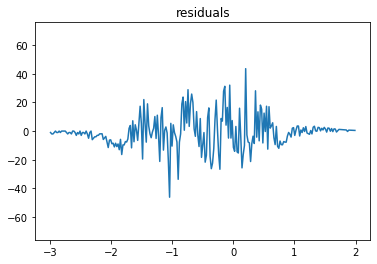

13
loading property model variables


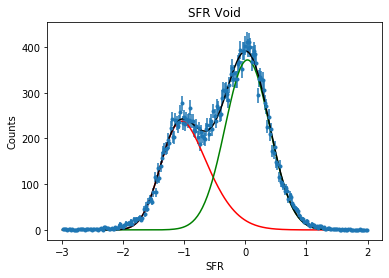

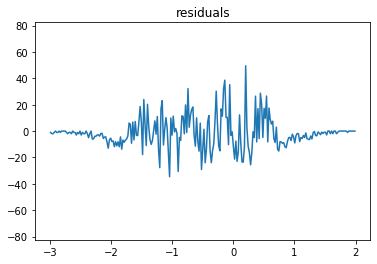

14
loading property model variables


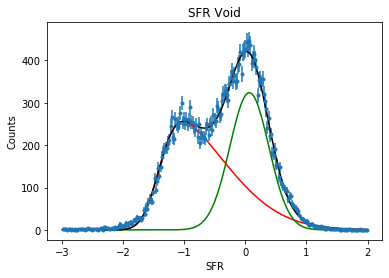

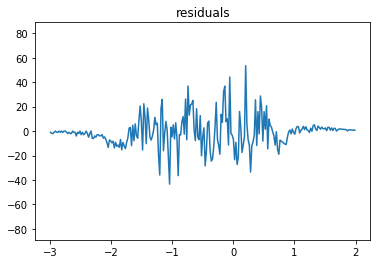

15
loading property model variables


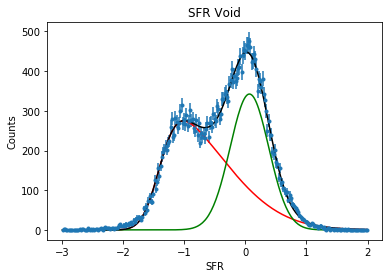

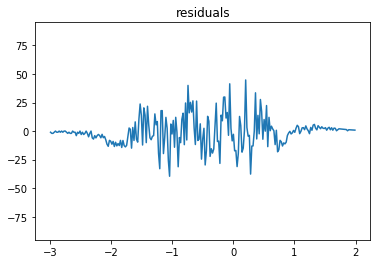

16
loading property model variables


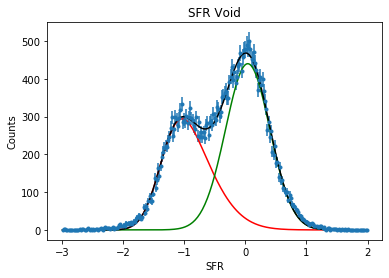

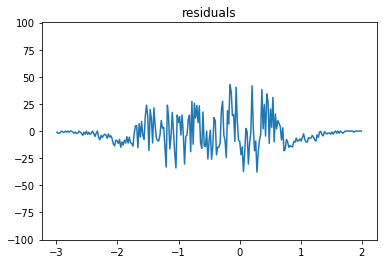

17
loading property model variables


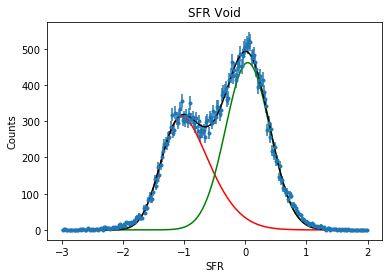

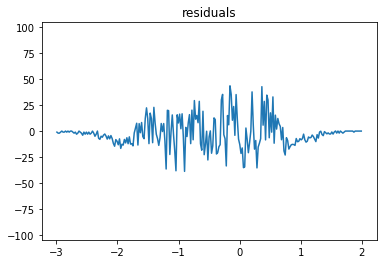

18
loading property model variables


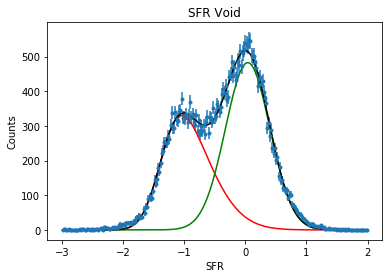

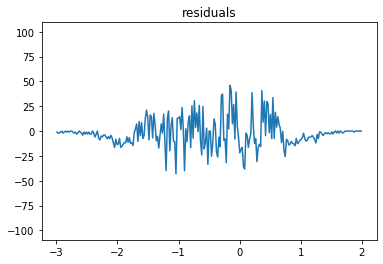

19
loading property model variables


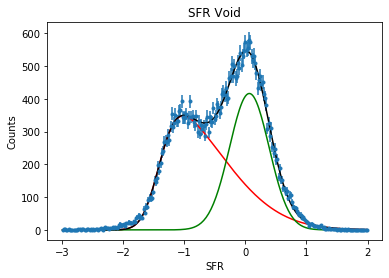

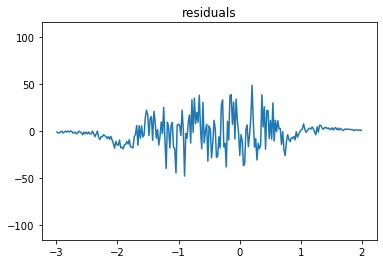

20
loading property model variables


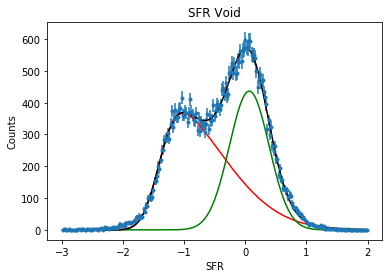

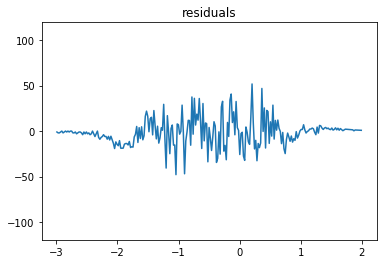

21
loading property model variables


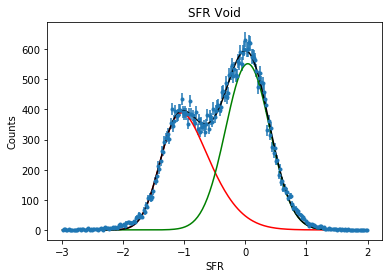

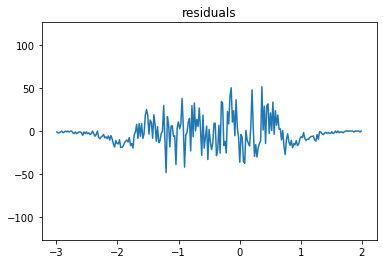

22
loading property model variables


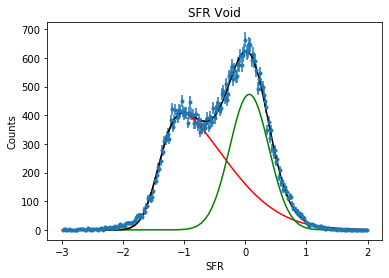

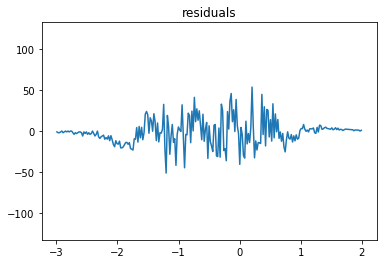

23
loading property model variables


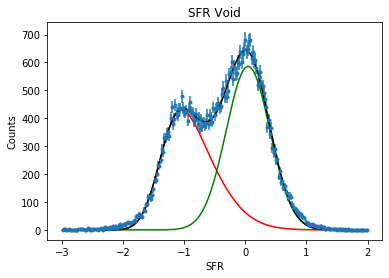

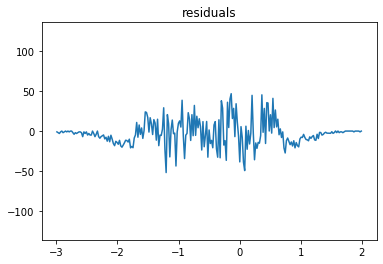

24
loading property model variables


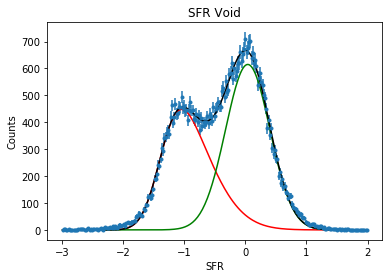

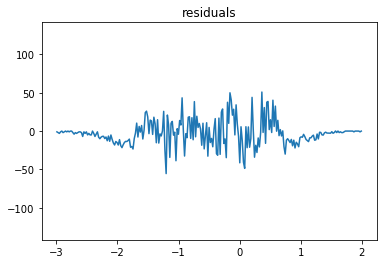

25
loading property model variables


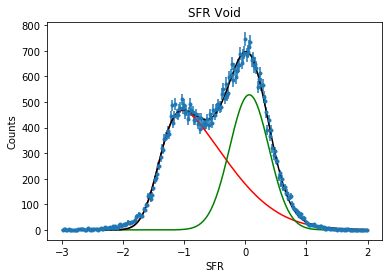

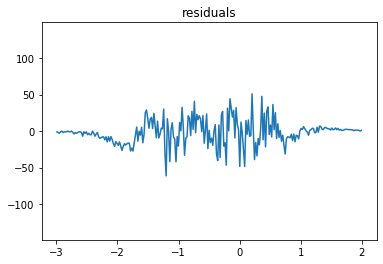

26
loading property model variables


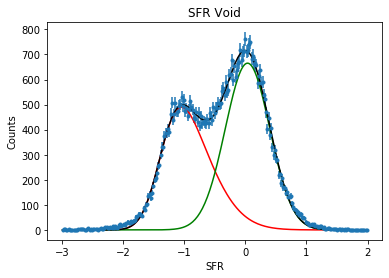

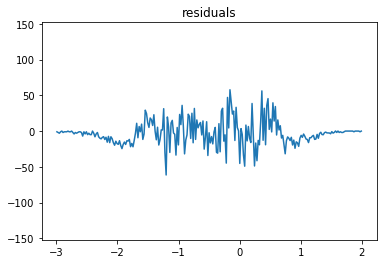

27
loading property model variables


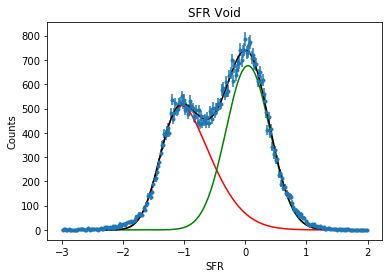

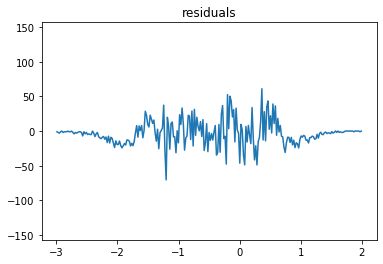

28
loading property model variables


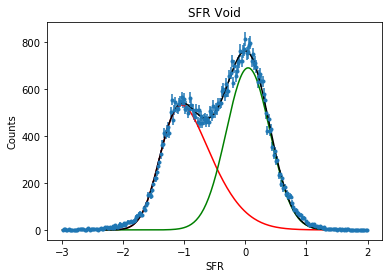

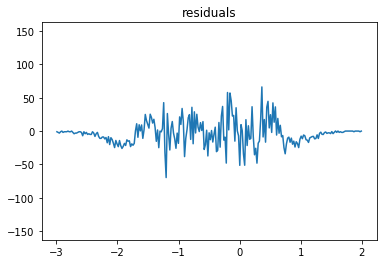

29
loading property model variables


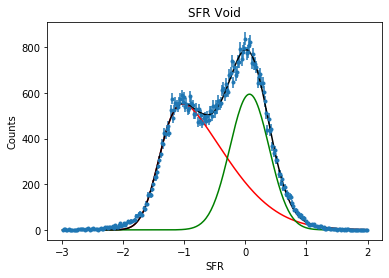

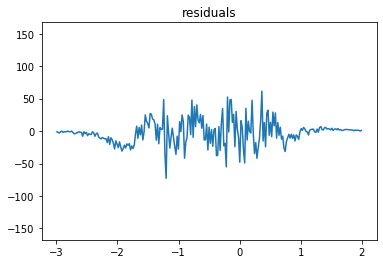

30
loading property model variables


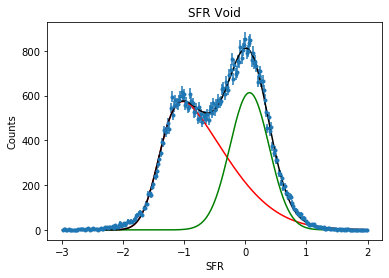

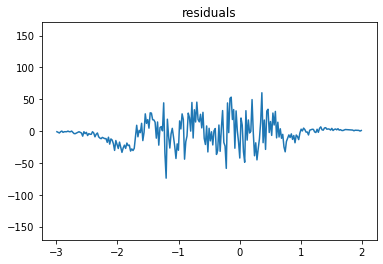

31
loading property model variables


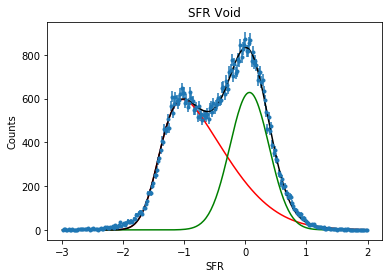

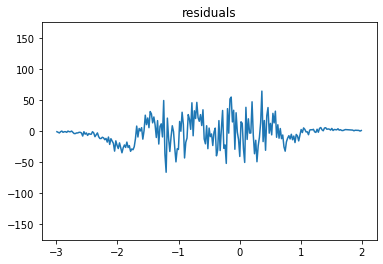

32
loading property model variables


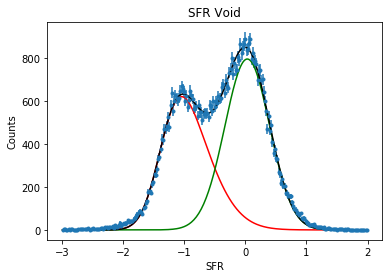

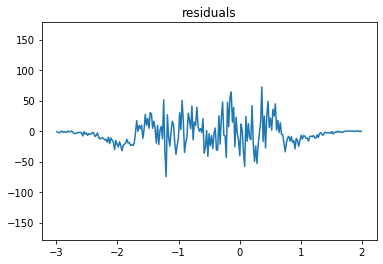

33
loading property model variables


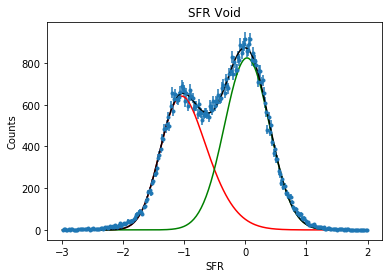

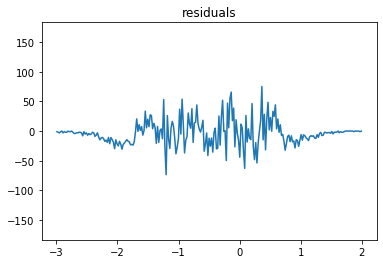

34
loading property model variables


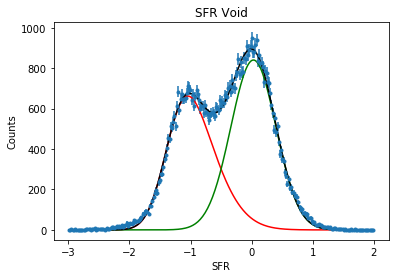

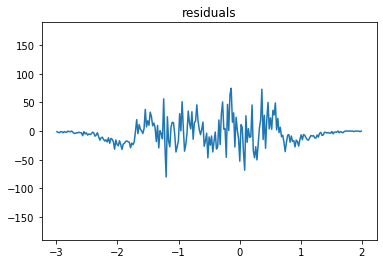

35
loading property model variables


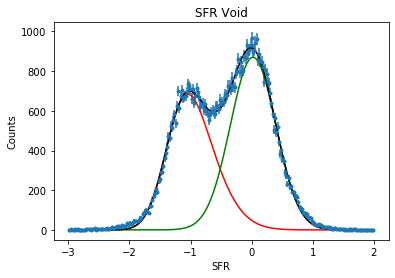

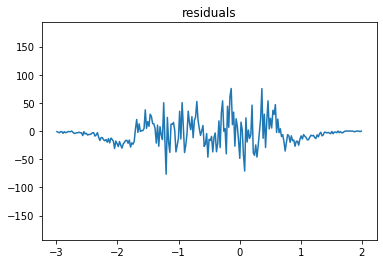

36
loading property model variables


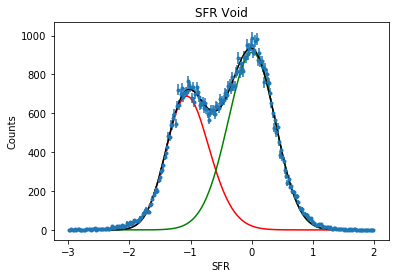

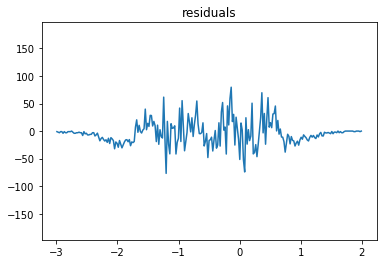

37
loading property model variables


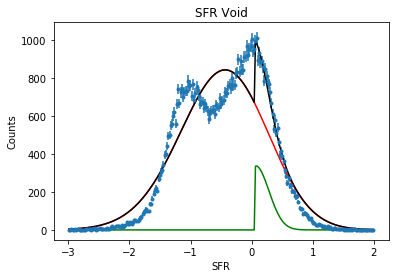

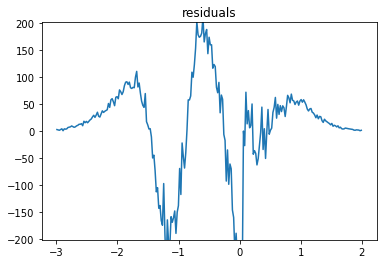

38
loading property model variables


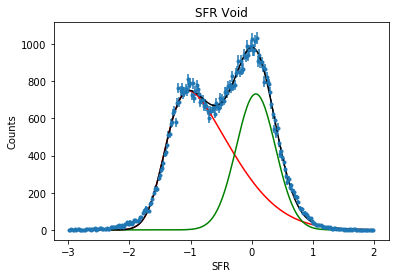

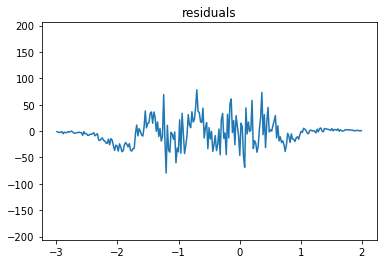

39
loading property model variables


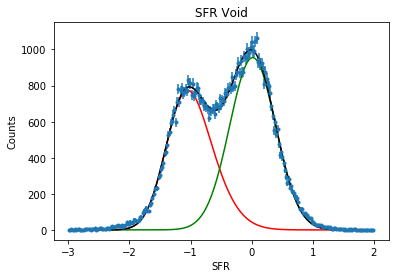

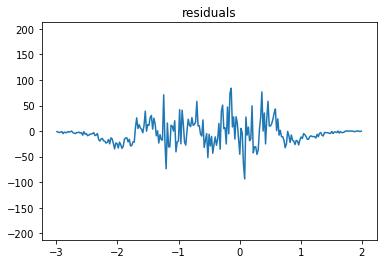

40
loading property model variables


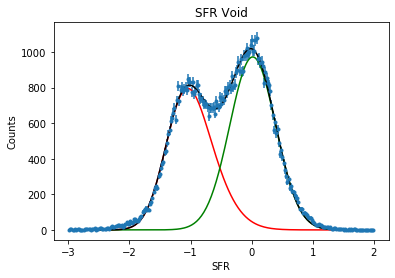

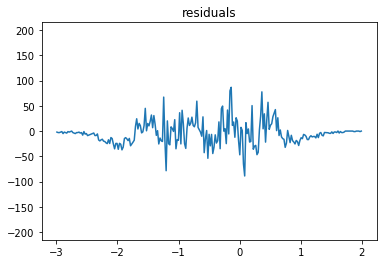

41
loading property model variables


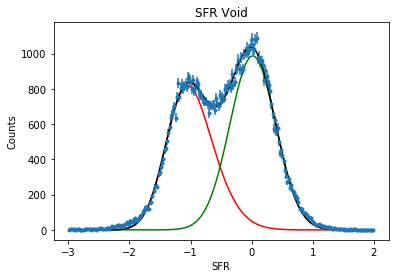

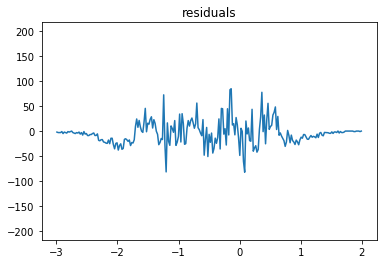

42
loading property model variables


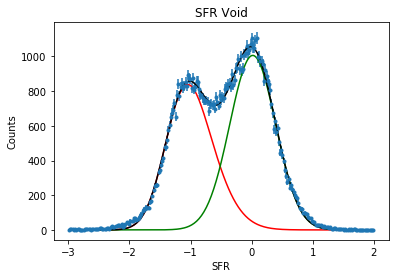

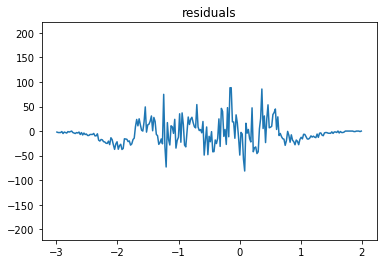

43
loading property model variables
44
loading property model variables
45
loading property model variables


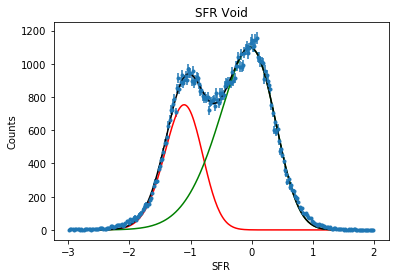

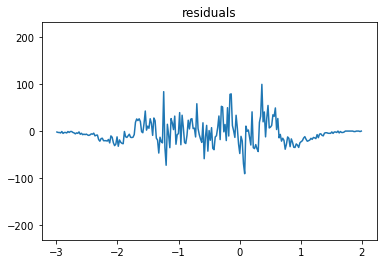

46
loading property model variables
47
loading property model variables


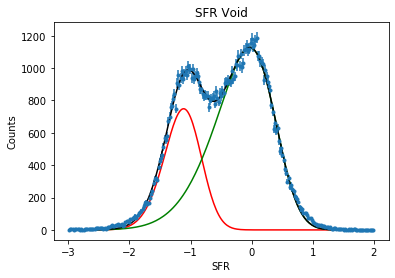

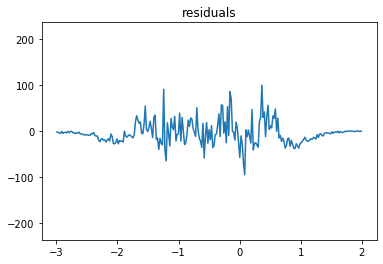

48
loading property model variables


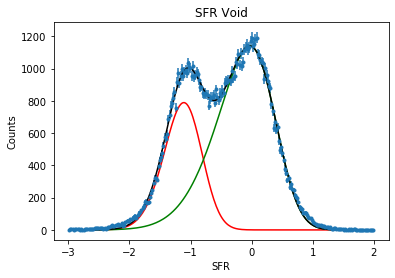

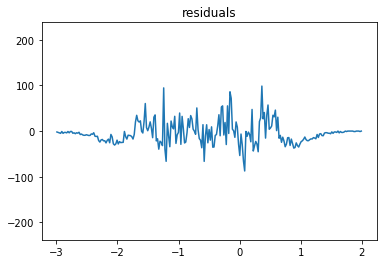

49
loading property model variables


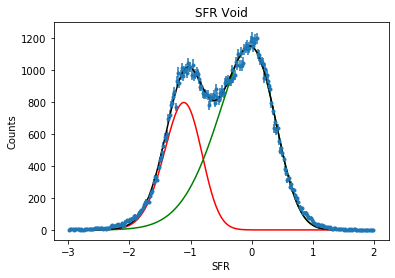

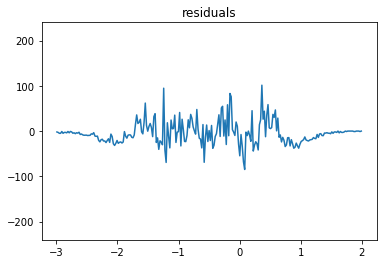

In [16]:
#normalized by the general distribution
amplitude_ratio = []
amplitude_ratio_err = []

# amplitude_diff = []
# amplitude_diff_err = []
# x_n = max_min(fit_all)[0] #max
# y_n = max_min(fit_all)[1]

index_pass = []
avg_depth = []
for i in range(len(ind_gal_depth_voidv2)):
    print(i)
    try:
        temp = bimodal_fit_void_separate(SFR[np.asarray(list(ind_gal_depth_voidv2[i]), dtype=int).flatten()], 'SFR', bins_=np.linspace(-3,2, 250))
#         print(temp[0][0],temp[0][4],temp[1][0],temp[1][4])
        temp1 = max_min(temp)
        x = temp1[0]#/x_n #max
        y = temp1[1]#/y_n #min
        
        dx = np.max([temp[1][4],temp[1][0]])#/np.max([fit_all[0][4],fit_all[0][0]])
        dy = np.min([temp[1][4],temp[1][0]])#/np.min([fit_all[0][4],fit_all[0][0]])
#         if x == temp[0][4]:
#             dx = temp[1][4]/np.max([fit_all[0][4],fit_all[0][0]])
#             dy = temp[1][0]/np.min([fit_all[0][4],fit_all[0][0]])

#         if x == temp[0][0]:
#             dx = temp[1][0]/np.max([fit_all[0][4],fit_all[0][0]])
#             dy = temp[1][4]/np.min([fit_all[0][4],fit_all[0][0]])
            
#         x = x/np.max([fit_all[0][4],fit_all[0][0]])
#         y = y/np.min([fit_all[0][4],fit_all[0][0]])
        
        amplitude_ratio.append(x/y)
#         amplitude_diff.append(x-y)
        amplitude_ratio_err.append(ampl_ratio_err(x,dx,y,dy))
#         amplitude_diff_err.append(ampl_diff_err(dx,dy))
        
    except (RuntimeError):
        index_pass.append(i)
        pass


In [17]:
amplitude_ratio = np.array(amplitude_ratio)
amplitude_ratio_err = np.array(amplitude_ratio_err)
# amplitude_diff = np.array(amplitude_diff)
# amplitude_diff_err = np.array(amplitude_diff_err)


In [18]:
x_ratio= np.delete(avg_depth_slice, index_pass)
# x_diff= np.delete(avg_depth_slice, index_pass)

In [19]:
len(ind_gal_depth_voidv2) - len(index_pass) == len(amplitude_ratio)

True

In [20]:
ind_ratio=0 # choose
ind_diff=0 # choose


In [21]:
dx_vf_void = np.max([VF_void[1][4],VF_void[1][0]]) #max
dy_vf_void = np.min([VF_void[1][4],VF_void[1][0]])

dx_fit_all = np.max([fit_all[1][4],fit_all[1][0]]) #max
dy_fit_all = np.min([fit_all[1][4],fit_all[1][0]])

x_vf_void=max_min(VF_void)[0]
y_vf_void=max_min(VF_void)[1]

x_fit_all=max_min(fit_all)[0]
y_fit_all=max_min(fit_all)[1]

ratio_err_vf_void = ampl_ratio_err(x_vf_void,dx_vf_void,y_vf_void,dy_vf_void)

In [22]:
dx_vf_void = np.max([VF_void[1][4],VF_void[1][0]]) #max
dy_vf_void = np.min([VF_void[1][4],VF_void[1][0]])

dx_fit_all = np.max([fit_all[1][4],fit_all[1][0]]) #max
dy_fit_all = np.min([fit_all[1][4],fit_all[1][0]])

x_vf_void=max_min(VF_void)[0]
y_vf_void=max_min(VF_void)[1]

x_fit_all=max_min(fit_all)[0]
y_fit_all=max_min(fit_all)[1]

ratio_err_vf_void = ampl_ratio_err(x_vf_void,dx_vf_void,y_vf_void,dy_vf_void)
ratio_err_fit_all = ampl_ratio_err(x_fit_all,dx_fit_all,y_fit_all,dy_fit_all)


In [23]:
x_vf_void,dx_vf_void

(1156.292907876931, 26.817762561190484)

In [26]:
y_vf_void_ratio= []
y_vf_void_diff = []

y_vf_void_ratio_err=[]
for i in range(len(x_ratio[ind_ratio:])):
    y_vf_void_ratio.append(x_vf_void/y_vf_void)
    y_vf_void_ratio_err.append(ratio_err_vf_void)
# for i in range(len(x_diff)):
# # for i in range(2):
#     y_vf_void_diff.append(max_min(VF_void)[0]-max_min(VF_void)[1])

    
all_ratio= []
# all_diff = []
y_fit_all_ratio_err=[]

for i in range(len(x_ratio[ind_ratio:])):
    all_ratio.append(x_fit_all/y_fit_all)
    y_fit_all_ratio_err.append(ratio_err_fit_all)
# for i in range(len(x_diff)):
# # for i in range(2):
#     all_diff.append(max_min(fit_all)[0]-max_min(fit_all)[1])

In [27]:
len(amplitude_ratio), len(x_ratio)#, len(y_vf_void_ratio), len(all_ratio)

(47, 47)

In [59]:
(y_vf_void_ratio- y_vf_void_ratio_err[0])[0]

1.4572145788196735

In [66]:
all_ratio, ratio_err_fit_all

([1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.1110056436358693,
  1.111005

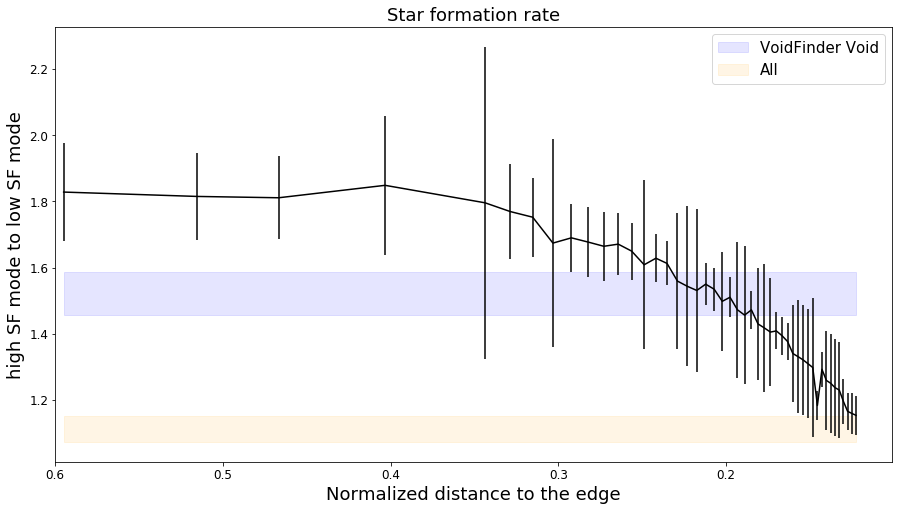

In [82]:
plt.figure(figsize=(15, 8))

# plt.errorbar(x_ratio,amplitude_ratio[ind_ratio:],yerr=amplitude_ratio_err[ind_ratio:] ,fmt= '-o')
plt.errorbar(np.flip(x_ratio[ind_ratio:]),amplitude_ratio[ind_ratio:], yerr=amplitude_ratio_err[ind_ratio:], color='black')
# plt.errorbar(x_ratio,y_vf_void_ratio, label="VoidFinder Void", c="green", yerr=y_vf_void_ratio_err)
# plt.errorbar(x_ratio,all_ratio, label="All",c="orange", yerr=ratio_err_fit_all)
plt.fill_between(np.flip(x_ratio), (y_vf_void_ratio- y_vf_void_ratio_err[0]), (y_vf_void_ratio+y_vf_void_ratio_err[0]), color='b', alpha=.1, label="VoidFinder Void")
plt.fill_between(np.flip(x_ratio), (all_ratio- y_fit_all_ratio_err[0]), (all_ratio+y_fit_all_ratio_err[0]), color='orange', alpha=.1, label="All")


plt.xlabel("Normalized distance to the edge",fontsize=18)
plt.ylabel("high SF mode to low SF mode",fontsize=18)
plt.title("Star formation rate",fontsize=18)
plt.xlim(0.6, 0.101)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15)
plt.show()


# # plt.errorbar(x_diff,amplitude_diff[ind_diff:],yerr=amplitude_diff_err[ind_diff:] ,fmt= '-o')
# plt.plot(x_diff,np.flip(amplitude_diff[ind_diff:]))
# plt.plot(x_diff,y_vf_void_diff, label="VoidFinder Void", c="green")
# plt.plot(x_ratio,all_diff,label="All",c="orange")

# # error bars get bigger as x,y gets bigger
# plt.xlabel("distance to edge (accumulative)",fontsize=15)
# plt.ylabel("peak difference",fontsize=15)
# plt.legend()
# plt.show()

In [ ]:
#solid line inside the shaded areas
# why are the error bars huge every 3 -4 bins?
# try 25 bins with equal amount of galaxies, still start close to the center of the void
# smaller bin error bars have about the same size,?
# push to git repository

In [47]:
y_vf_void_ratio[0]-y_vf_void_ratio_err[0]

1.4572145788196735

In [43]:
y_vf_void_ratio_err

[0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.06406057178942705,
 0.0640605

In [49]:
#create some random data
np.random.seed(0)
x = np.random.randint(1, 10, 30)
y = x+np.random.normal(0, 1, 30)

#create regplot
# ax = sns.regplot(x, y)

In [52]:
len(x), len(y)

(30, 30)